# Fig. 2: Density of pericentromeric and subtelomeric repeats in *Xenopus tropicalis*. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib import colors
import string
import matplotlib.patches as patches
import copy
import os

## Input files

In [2]:
source_data_path = 'SourceData'
fig_2 = 'Fig.2'
paths_files_fig_2 = os.path.join(source_data_path, fig_2)

'SourceData/Fig.2'

In [16]:

centromere_file = os.path.join(paths_files_fig_2, 'Xtr_centromeric_repeats.tsv')
genetic_map_file =  os.path.join(paths_files_fig_2, 'finalV10Map.joinmap.toplot.tsv')
subtelo_repeat_file = os.path.join(paths_files_fig_2, 'RepeatDensity_SubTelomeric.tab')
pericen_repeat_file = os.path.join(paths_files_fig_2, 'RepeatDensity_PeriCentromeric.tab')
Xtr_chr_sizes_file = os.path.join(paths_files_fig_2, 'Xentr10.chrom.sizes')
Pericent_Subtelomere_boundaries_file = os.path.join(paths_files_fig_2, 'Pericent_Subtelomere_boundaries.tsv')  #Obtained from the PEAK of PCA1 on pericentromere.
genetic_rec_file = os.path.join(paths_files_fig_2, 'Xtropicalis_Recombination_Rates_Final.tsv')


In [11]:
Mb = 1000000
chr_sizes = pd.read_csv(Xtr_chr_sizes_file, sep='\t', names=["Chr","Length"])
PeriCent_SubTelomere_bounds = pd.read_csv(Pericent_Subtelomere_boundaries_file, sep='\t')
PeriCent_SubTelomere_bounds

Chr     Start       End  Start_p     End_p    Start_q      End_q  \
0   Chr1  82600000  97600000        0  30000000  187471166  217471166   
1   Chr2  59400000  74400000        0  30000000  151034961  181034961   
2   Chr3   8000000  23000000        0   7000000  123873357  153873357   
3   Chr4  38600000  53600000        0  30000000  123961319  153961319   
4   Chr5  53800000  68800000        0  30000000  134033575  164033575   
5   Chr6  65800000  80800000        0  30000000  124486312  154486312   
6   Chr7  51600000  66600000        0  30000000  103565930  133565930   
7   Chr8  11600000  26600000        0  10600000  117241510  147241510   
8   Chr9  35600000  50600000        0  30000000   61218944   91218944   
9  Chr10  13400000  28400000        0  12400000   29400000   52432566   

     Length  
0  60000000  
1  60000000  
2  37000000  
3  60000000  
4  60000000  
5  60000000  
6  60000000  
7  40600000  
8  60000000  
9  35432566

In [19]:
out_dir_figs = paths_files_fig_2

# Load files:
#repeat_masker_file = ''.join((paths_files_fig_5,'Xentr10__RM_withJCs.tab'))  ###Repeat masker file with JC metrics
#repeat_motif_file  = ''.join((paths_files_fig_5,'Xentr10__RDpb_Motif.tab'))
#repeat_classes_file = ''.join((paths_files_fig_5,'Xentr10__RDpb_Class.tab'))
#species_table_file = ''.join((paths_files_fig_5,'Species_table_final.tab'))
#Xtrop_centromere_positon = load_Centromeric_positions_for_Xtr('~SAPS/X_tropicalis_V10_Final/DATA_OUT/Xtr_centromeric_repeats.tab')
#chr_sizes_xtr = load_all_chromosome_sizes('~SAPS/X_tropicalis_V10_Final/DATA_OUT/All_Chr_lengths.tab', 'Xtr')
#Rec_rate = load_Recombination('~/SAPS/X_tropicalis_V10_Final/DATA_OUT/NR_Densities/Xtropicalis_Recombination_Rates_Final.tab')  ###File produced at the end of the notebook if necessary

def load_Densities(file_path):
    Motifs = pd.read_csv(file_path, sep='\t', index_col=0)
    Motifs = Motifs.fillna(0)
    return(Motifs)


SubTelomeric = load_Densities(subtelo_repeat_file)
PeriCentromeric = load_Densities(pericen_repeat_file)
Xtrop_centromere_positon = pd.read_csv(centromere_file , sep='\t')
Motifs_and_Classes = pd.merge(SubTelomeric,PeriCentromeric)
Rec_rate = pd.read_csv(genetic_rec_file, sep='\t')

In [8]:
#### See Fig S10: Recombination Rates notebook for more information/figures

# Linear interpolation for every 3Mb
# Then cubicSplice for every 1Mb

from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

Mb = 1000000

def obtain_increasing_cMs(cM, pos):
    prev_i = cM[0]
    prev_pos= pos[0]
    positive_cM_arr = []
    positive_pos_arr = []
    positive_cM_arr.append(prev_i)
    positive_pos_arr.append(prev_pos)
    for i in range(0, len(cM)):
        if (cM[i]>= prev_i ) & (prev_pos<pos[i]):
            prev_i = cM[i]
            positive_cM_arr.append(cM[i])        
            positive_pos_arr.append(pos[i])
            prev_i = cM[i]
            prev_pos = pos[i]
    return(positive_cM_arr,positive_pos_arr)

def linear_genetic_map(Genetic_map, chr_sizes , win_size):
    # The genetic map distances were linearly interpolated using a 3 Mb window size, the interpolated values were smoothed using cubic splines 1 Mbps.
    
    win_size = int(win_size)

    Mb = 1000000
    #win_size = Mb*3
    
    RecombinationRate = pd.DataFrame()
    
    n_original_markers = 0  
    n_kept_makers = 0
    for each_chr  in chr_sizes.Chr.to_list():
        chr_size_ = int(list(chr_sizes[chr_sizes.Chr==each_chr].Length)[0])
        
        RecombinationRate_df = pd.DataFrame() 
        
        pos = np.array(Genetic_map[Genetic_map['Chr']==each_chr].Pos.tolist()) 
        cM =  np.array(Genetic_map[Genetic_map['Chr']==each_chr].cM.tolist()) 
        n_original_markers = n_original_markers + len(cM)
        #print("# orig. genetic markers:", each_chr, len(cM))
        cM, pos = obtain_increasing_cMs(cM, pos)
        n_kept_makers = n_kept_makers + len(cM)
        #print("#  genetic markers kept:", each_chr, len(cM))
        cont_positon = np.array(range(min(pos), max(pos), win_size))
        if cont_positon[-1] < max(pos):
            cont_positon = np.append(cont_positon,pos[-1])
        
        lin_interpolation = interp1d(np.array(pos), np.array(cM))
        y1 = lin_interpolation(cont_positon)
        
        cs = CubicSpline(cont_positon, y1)

        cont_positon2 = np.array(range(min(Genetic_map[Genetic_map['Chr']==each_chr].Pos), max(Genetic_map[Genetic_map['Chr']==each_chr].Pos)+Mb/2, Mb/2))        
        y2 = cs(cont_positon2)
        
        RecombinationRate_df['Chr'] = [each_chr]*len(cont_positon2)
        RecombinationRate_df['Pos'] = list(cont_positon2 )
        RecombinationRate_df['Pos'] = RecombinationRate_df.Pos.astype(int)
        RecombinationRate_df['delta_pos']   =   list(np.array(RecombinationRate_df['Pos'])[1:]-np.array(RecombinationRate_df['Pos'])[:-1]) +[0]
        RecombinationRate_df['Smooth_Genetic_distance'] =   y2
        RecombinationRate_df['delta_CC']       = list(np.array(RecombinationRate_df['Smooth_Genetic_distance'])[1:]-np.array(RecombinationRate_df['Smooth_Genetic_distance'])[:-1]) + [0]
        RecombinationRate_df['Smooth_Recombination_Rate'] =  RecombinationRate_df['delta_CC']*Mb/RecombinationRate_df['delta_pos']
        
        RecombinationRate = RecombinationRate.append(RecombinationRate_df)
        
    RecombinationRate = RecombinationRate[['Chr','Pos','delta_pos','delta_CC','Smooth_Genetic_distance','Smooth_Recombination_Rate']]
    RecombinationRate = RecombinationRate.reset_index()
    
    print("n_original_markers", n_original_markers)
    print("n_kept_makers", n_kept_makers)
    return(RecombinationRate)



In [9]:
genetic_map_version = '_Final'
Genetic_map = pd.read_csv(genetic_map_file,sep='\t')
Genetic_map['Pos'] = Genetic_map.Pos.astype(int)
Genetic_map = Genetic_map.sort_values(['Chr','Pos'], ascending=[True,True])

win_size = 2.5*Mb
Rec_rate = linear_genetic_map(Genetic_map, chr_sizes, 2.5*Mb)

Rec_rate['Start'] = Rec_rate.Pos +  Rec_rate.delta_pos/2

High_rec_lim = Rec_rate.Smooth_Recombination_Rate.median() + .75*Rec_rate.Smooth_Recombination_Rate.std()
print("High_rec_lim = ", High_rec_lim)
Rec_rate['Rec_rate']= 'Low'
Rec_rate.loc[Rec_rate.Smooth_Recombination_Rate>=High_rec_lim, 'Rec_rate' ] ='High'


Total_chr_size_inMb = chr_sizes.Length.sum()/Mb
Positions_from_genetic_map = int(Genetic_map.groupby('Chr').agg({'Pos': lambda x: max(x)-min(x)}).sum()/Mb)
Total_portionGenome_weObtained_RecombinationRate = int(Rec_rate.groupby('Chr').agg({'Pos': lambda x: max(x)-min(x)}).sum()/Mb)
Percentage_genome_weObtained_RecombinationRate = Total_portionGenome_weObtained_RecombinationRate/float(Total_chr_size_inMb)

print("Total_chr_size_inMb", Total_chr_size_inMb)
print("Total_portionGenome_weObtained_RecombinationRate", Total_portionGenome_weObtained_RecombinationRate)
print("% genome with RecombinationRate values", Percentage_genome_weObtained_RecombinationRate*100)



n_original_markers 1277
n_kept_makers 1168
High_rec_lim =  1.1561561678890895
Total_chr_size_inMb 1449
Total_portionGenome_weObtained_RecombinationRate 1349
% genome with RecombinationRate values 93.0986887509


In [10]:
#recombination_rates_file = ''.join((source_data_path,'Supplementary_Fig.11/Xtropicalis_Recombination_Rates_Final.tab'))
recombination_rates_file = os.path.join(paths_files_fig_2,'Xtropicalis_Recombination_Rates_Final.tab')
Rec_rate = pd.read_csv(recombination_rates_file, sep='\t')
Rec_rate.head()

Chr      Pos  delta_pos  delta_CC  Smooth_Genetic_distance  \
0  Chr1  4000000     500000  0.845459                 0.000000   
1  Chr1  4500000     500000  1.021646                 0.845459   
2  Chr1  5000000     500000  1.181592                 1.867105   
3  Chr1  5500000     500000  1.325296                 3.048697   
4  Chr1  6000000     500000  1.452757                 4.373993   

   Smooth_Recombination_Rate      Start Rec_rate     Chr domain   Chr domains  
0                   1.690918  4250000.0     High  p-Subtelomere  Subtelomeres  
1                   2.043293  4750000.0     High  p-Subtelomere  Subtelomeres  
2                   2.363184  5250000.0     High  p-Subtelomere  Subtelomeres  
3                   2.650591  5750000.0     High  p-Subtelomere  Subtelomeres  
4                   2.905515  6250000.0     High  p-Subtelomere  Subtelomeres

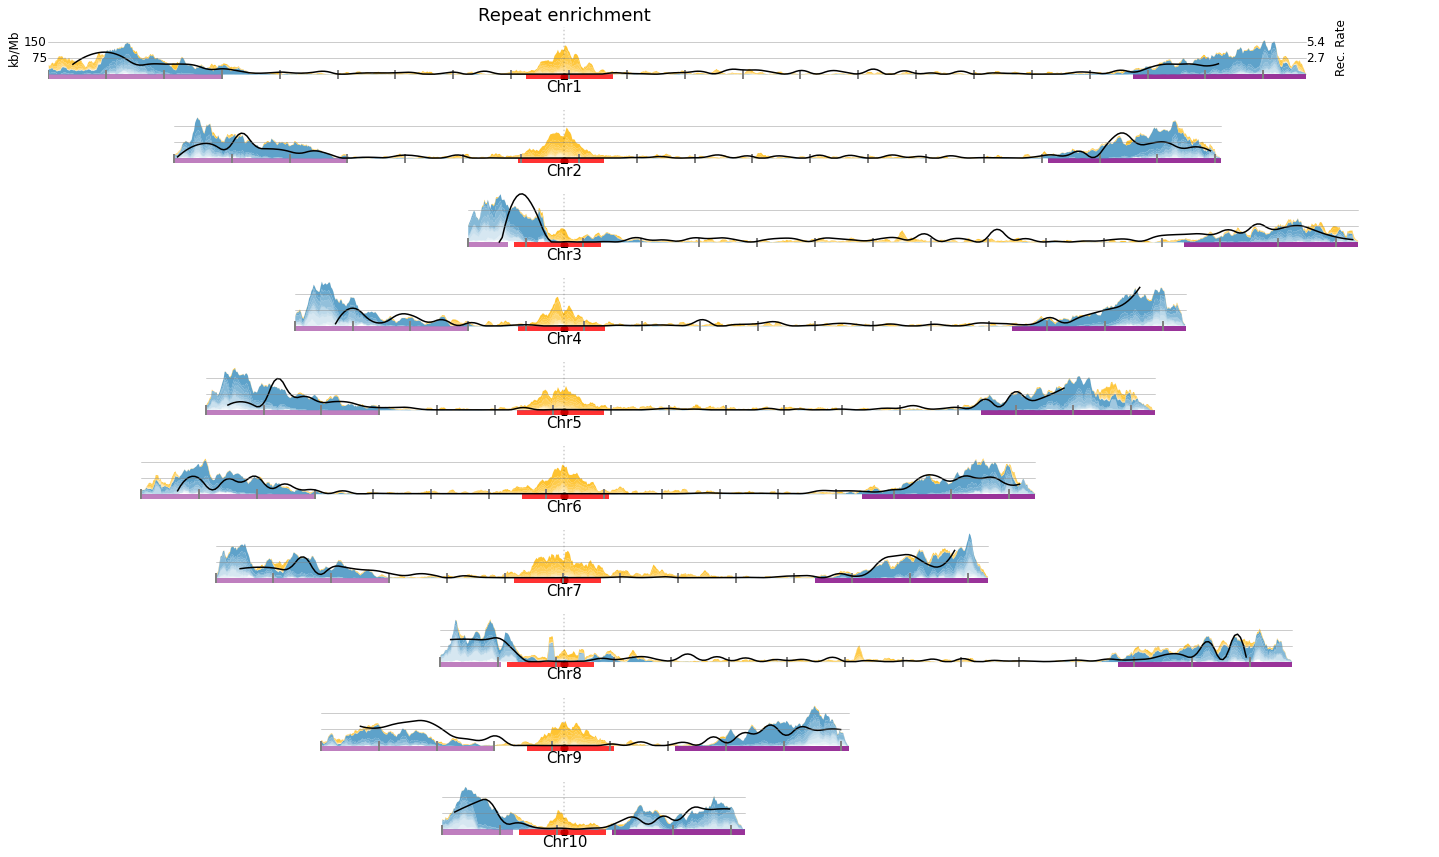

In [21]:
Repeats_SubTelomeric = SubTelomeric.columns[2:]
Repeats_PeriCentromeric = PeriCentromeric.columns[2:]

Mb = 1000000
Acomp_color_y='#FEC024' # (255/N_256,220/N_256,139/N_256) ##'#ffc125'
Bcomp_color_b='#509AC6' #(186/N_256,212/N_256,229/N_256) ##'#4e98bb'

title = 'Repeat enrichment'

list_chromosomes = chr_sizes.Chr.tolist()
CTR_pos_Chr1 = list(Xtrop_centromere_positon[Xtrop_centromere_positon.Chr=='Chr1'].TandemRepeats)[0]
Largest_chr_len = float(chr_sizes.Length.max())*1.1

max_y_value, max_axis = 1,1
min_axis = 0

counter = 0
fig, axs = plt.subplots(len(list_chromosomes), figsize=(20,1.2*len(list_chromosomes)))


for Chr_ in list_chromosomes:    
    To_plot = Motifs_and_Classes[Motifs_and_Classes.Chr==Chr_]
    
    Chr_size_ = list(chr_sizes[chr_sizes.Chr==Chr_].Length)[0]
    CTR_pos = list(Xtrop_centromere_positon[Xtrop_centromere_positon.Chr==Chr_].TandemRepeats)[0]
    delta_centromere = CTR_pos_Chr1 - CTR_pos
    CTR_pos_normalized =(CTR_pos+delta_centromere)/Largest_chr_len
    chr_size_normalized = (Chr_size_+delta_centromere)/Largest_chr_len

    CTR_pos_normalized_ = (list(Xtrop_centromere_positon[Xtrop_centromere_positon.Chr==Chr_].TandemRepeats)[0]+delta_centromere)/Largest_chr_len
    axs[counter].scatter(CTR_pos_normalized_, 0.05, alpha=1, s=50, color='black', edgecolors='black',  marker="o")
    if counter == 0:
        axs[counter].text(CTR_pos_normalized,(max_axis)*1.1,title, fontsize=18, horizontalalignment='center')

    axs[counter].set_xlim((0, 1))
    axs[counter].set_ylim((min_axis*1.3, max_axis*1.1))
    axs[counter].text((CTR_pos+delta_centromere)/Largest_chr_len, -.225, Chr_, fontsize=15, ha='center')

    axs[counter].axvline(CTR_pos_normalized_, ymin=0, ymax=.9,  alpha=.2, color='black', linewidth=1.5, linestyle=":")
    #axs[counter].axvline((Centurion3[Centurion3.Chr==Chr_].Centurion.to_list()[0] +delta_centromere)/Largest_chr_len , ymin=0, ymax=.9,  alpha=.25, color='black', linewidth=2, linestyle="--")
 
    #Pericentromere (Red)
    axs[counter].add_patch(patches.Rectangle(( (PeriCent_SubTelomere_bounds[PeriCent_SubTelomere_bounds.Chr==Chr_].Start.to_list()[0]  +delta_centromere)/Largest_chr_len,0) ,15*Mb/Largest_chr_len, .099,linewidth=1,facecolor='red', alpha=0.8))
    #Subtelomeres (Purple)
    STp_lim=(PeriCent_SubTelomere_bounds[PeriCent_SubTelomere_bounds.Chr==Chr_].End_p.to_list()[0] )/Largest_chr_len
    STq_lim=(PeriCent_SubTelomere_bounds[PeriCent_SubTelomere_bounds.Chr==Chr_].End_q.to_list()[0] -PeriCent_SubTelomere_bounds[PeriCent_SubTelomere_bounds.Chr==Chr_].Start_q.to_list()[0] )/Largest_chr_len
    axs[counter].add_patch(patches.Rectangle((delta_centromere/Largest_chr_len,0) ,STp_lim, .099,linewidth=1,facecolor='purple', alpha=0.5))
    axs[counter].add_patch(patches.Rectangle(((PeriCent_SubTelomere_bounds[PeriCent_SubTelomere_bounds.Chr==Chr_].Start_q.to_list()[0]  +delta_centromere)/Largest_chr_len ,0) ,STq_lim, .099,linewidth=1,facecolor='purple', alpha=0.8))

    for tick_10Mb in range(0, Chr_size_, 10*Mb):
        normalized_tick = (tick_10Mb  +delta_centromere)/Largest_chr_len  
        axs[counter].axvline(normalized_tick, ymin=0, ymax= .15,  alpha=1, color='gray', linewidth=2)
        
    past = np.array([0]*To_plot.shape[0])
    past_old = past
    alpha_inc =0
    for i in Repeats_SubTelomeric:
        past=past+np.array(To_plot[i])
        axs[counter].fill_between(((To_plot.Start+ delta_centromere)/Largest_chr_len),   past/250000+.1, past_old/250000+.1, color=Bcomp_color_b, linewidth=0, alpha=alpha_inc); 
        past_old = past
        alpha_inc = alpha_inc+ 1/float(len(Repeats_SubTelomeric))
    alpha_inc=0
    for i in Repeats_PeriCentromeric:
        past=past+np.array(To_plot[i])
        axs[counter].fill_between(((Motifs_and_Classes[Motifs_and_Classes.Chr==Chr_].Start+ delta_centromere)/Largest_chr_len), past/250000+.1, past_old/250000+.1,color=Acomp_color_y, linewidth=0, alpha=alpha_inc);
        past_old = past
        alpha_inc = alpha_inc+ 1/float(len(Repeats_PeriCentromeric))
    
    axs[counter].plot(((((Rec_rate[Rec_rate.Chr==Chr_].Pos + Rec_rate[Rec_rate.Chr==Chr_].delta_pos/2)) + delta_centromere)/Largest_chr_len),.9*(Rec_rate[Rec_rate.Chr==Chr_].Smooth_Recombination_Rate/Rec_rate.Smooth_Recombination_Rate.max())+.1, color='black')
        
    axs[counter].spines['top'].set_visible(False)
    axs[counter].spines['right'].set_visible(False)
    axs[counter].spines['bottom'].set_visible(False)
    axs[counter].spines['left'].set_visible(False)
    axs[counter].get_xaxis().set_ticks([])
    axs[counter].get_yaxis().set_ticks([])
    
    if counter == 0:
        axs[counter].text(-0.001,(250000/250000)*float(.6)+.1,str(int((250000*.6)/1000)), fontsize=12, horizontalalignment='center', va='center', ha='right')
        axs[counter].text(-0.001,(250000/250000)*float(.3)+.1,str(int((250000*.3)/1000)), fontsize=12, horizontalalignment='center', va='center', ha='right')
        axs[counter].text(-0.025,(250000/250000)*float(.5)+.1,str('kb/Mb'), fontsize=12, horizontalalignment='center', va='center', ha='center',  rotation='90') 
        
        axs[counter].text(chr_size_normalized,(250000/250000)*float(.6)+.1, str(1.1*Rec_rate.Smooth_Recombination_Rate.max()*.6)[:3], fontsize=12, horizontalalignment='center', va='center', ha='left') 
        axs[counter].text(chr_size_normalized,(250000/250000)*float(.3)+.1, str(1.1*Rec_rate.Smooth_Recombination_Rate.max()*.3)[:3], fontsize=12, horizontalalignment='center', va='center', ha='left') 
        axs[counter].text(chr_size_normalized+0.025,(250000/250000)*float(.5)+.1, str('Rec. Rate'), fontsize=12, horizontalalignment='center', va='center', ha='center',  rotation='90') 
    axs[counter].axhline((250000/250000)*float(.6)+.1,xmin=delta_centromere/Largest_chr_len,xmax=chr_size_normalized, color='grey', linewidth=.5, alpha=.8)
    axs[counter].axhline((250000/250000)*float(.3)+.1,xmin=delta_centromere/Largest_chr_len,xmax=chr_size_normalized, color='grey', linewidth=.5, alpha=.8)
    

    counter=counter+1
    
#plt.legend(bbox_to_anchor=(.2,1), frameon=False)    
plt.tight_layout()
out_fig_name = os.path.join(paths_files_fig_2, fig_2 + '.svg')
print("Saved as", out_fig_name)
plt.savefig(out_fig_name,bbox_inches='tight', transparent=True)
plt.show()
